# AI_Search_Strategies_and_Genetic_Optimization

## 1 Introduction
The task distribution is:
+ Agenda-based search: 60%
+ Adversarial search: 40%

In [282]:
!pip install pandas

In [283]:
!pip install matplotlib

In [284]:
!pip install networkx

In [285]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [286]:
df = pd.read_csv("tubedata.csv", header=None)
df.head()

,0,1,2,3,4,5
0,Harrow & Wealdstone,Kenton,Bakerloo,3,5,0
1,Kenton,South Kenton,Bakerloo,2,4,0
2,South Kenton,North Wembley,Bakerloo,2,4,0
3,North Wembley,Wembley Central,Bakerloo,2,4,0
4,Wembley Central,Stonebridge Park,Bakerloo,3,4,0


## 2 Agenda Based Search
### 2.1 Implement DFS, BFS and UCS
Implement DFS, BFS and UCS to find routes from a starting station to a destination station. For
a path found, your program should print/display the following information: path in stations, cost in
average time, number of nodes expanded. The route from Euston to Victoria is a good one for testing.
Briefly describe how to launch the program and mention its main files in your report.
First, you need to think about how to represent a state and how to construct a new state from each
station reachable from the current state (but not already visited in the current path so far) this may
include current station, line and zone, path and cost so far. Describe the state representation in your
report

In [287]:
from collections import defaultdict
station_dict = defaultdict(list)
zone_dict = defaultdict(set)

# get data row by row
for index, row in df.iterrows():
    start_station = row[0]
    end_station = row[1]
    act_cost = int(row[3])

    start_zone = row[4]
    end_zone = row[5]

    # station dictionary of child station tuples (child_name, cost from parent to the child)
    # {"Mile End": [("Stepney Green", 2), ("Wembley", 1)]}
    # {start_station: [(end_station, act_cost)]}
    station_list = station_dict[start_station]
    station_list.append((end_station, act_cost))

    # the following two lines add the other direction of the tube "step"
    station_list = station_dict[end_station]
    station_list.append((start_station, act_cost))

    # we add the main zone
    zone_dict[start_station].add(start_zone)
    # we add the secondary zone
    if end_zone != "0":
        zone_dict[start_station].add(end_zone)
        # if the secondary zone is not 0 it's the main zone for the ending station
        zone_dict[end_station].add(end_zone)
    else:
        # otherwise the main zone for the ending station is the same as for the starting station
        zone_dict[end_station].add(start_zone)

#print(f"Station dictionary: {station_dict}")
#print(f"Zone dictionary: {zone_dict}")

State representation

In [288]:
class State_Representation:
    def __init__(self, current_station, line, zone, path, cost, station_visited, station_visited_inverse):
        self.current_station = current_station
        self.line = line
        self.zone = zone
        self.path = path
        self.cost = cost
        self.station_visited = station_visited
        self.station_visited_inverse = station_visited_inverse

    def __str__(self):
        return f"State_Representation is ({self.current_station}, {self.line}, {self.zone}, {self.path}, {self.cost})"


### 2.2 Compare DFS, BFS and UCS
Make a detailed comparison of the three search methods. For this, make sure you try out a good
number of different routes, including the ones below, and base your comparison on the costs in terms
of the average time (even if not considered by DFS and BFS) and the number of nodes expanded for
the different methods. Answer the following questions in your report:
+ Is any method consistently better?
+ Report the returned path costs in terms of the count of the visited nodes for one route below
(or any route of your choice) and explain your results based on the knowledge of costs each
algorithm considers.
+ Report the returned path costs in terms of the average time taken for one route below (or any
route of your choice) and explain your results based on the knowledge of costs each algorithm
considers.
+ Report the returned path costs in terms of the visited nodes and the average time taken for one
route below (or any route of your choice) for two different orders to process the nodes (direct and
inverse order of explored nodes at each level) and explain your results for the three algorithms.
+ Explain how you overcame the loop issue in your code.
Examples of routes you may include in your comparison:
    + Canada Water to Stratford
    + New Cross Gate to Stepney Green
    + Ealing Broadway to South Kensington
    + Baker Street to Wembley Park

In [289]:
#Depth First Search(DFS)
def depth_first_search(graph, start, end, inverse_order=False):
    station_visited = set()
    station_visited_inverse = set()
    current_stack = [State_Representation(start, None, None, [], 0, station_visited, station_visited_inverse)]

    while current_stack:
        current_state = current_stack.pop()
        current_station = current_state.current_station

        if inverse_order:
            station_visited = current_state.station_visited_inverse
        else:
            station_visited = current_state.station_visited

        if current_station in station_visited:
            continue

        if current_station == end:
            print(f"\033[1m--------------------------- DEPTH-FIRST-SEARCH -----------------------------\033[0m")
            return current_state

        if current_station not in station_visited:
            station_visited.add(current_station)

            neighbors = graph[current_station]

            if inverse_order:
                neighbors = neighbors[::-1]

            for neighbor, cost in neighbors:
                if neighbor not in station_visited:
                    new_state = State_Representation(neighbor, None, None, current_state.path + [current_station],
                                                    current_state.cost + cost, station_visited, station_visited_inverse)
                    current_stack.append(new_state)

    return None

#Breadth First Search(BFS)
def breadth_first_search(graph, start, end, inverse_order=False):
    station_visited = set()
    station_visited_inverse = set()
    current_queue = [State_Representation(start, None, None, [], 0, station_visited, station_visited_inverse)]

    while current_queue:
        current_state = current_queue.pop(0)
        current_station = current_state.current_station

        if inverse_order:
            station_visited = current_state.station_visited_inverse
        else:
            station_visited = current_state.station_visited

        if current_station in station_visited:
            continue

        if current_station == end:
            print(f"\033[1m---------------------------- BREADTH-FIRST-SEARCH ------------------------------\033[0m")
            return current_state

        if current_station not in station_visited:
            station_visited.add(current_station)

            neighbors = graph[current_station]

            if inverse_order:
                neighbors = neighbors[::-1]

            for neighbor, cost in neighbors:
                if neighbor not in station_visited:
                    new_state = State_Representation(neighbor, None, None, current_state.path + [current_station],
                                                    current_state.cost + cost, station_visited, station_visited_inverse)
                    current_queue.append(new_state)

    return None

#Uniform Cost Search
def uniform_cost_search(graph, start, end, inverse_order=False):
    start_visited_set = set()
    start_state = State_Representation(start, None, None, [], 0, start_visited_set, set())
    current_priority_queue = [start_state]

    while current_priority_queue:
        current_state = current_priority_queue.pop(0)
        current_station = current_state.current_station
        visited_set = current_state.station_visited

        if current_station in visited_set:
            continue

        if current_station == end:
            print("\033[1m-----------------------------UNIFORM-COST-SEARCH ---------------------------------\033[0m")
            return current_state

        visited_set.add(current_station)

        neighbors = graph[current_station]

        if inverse_order:
            neighbors = neighbors[::-1]

        for neighbor, cost in neighbors:
            if neighbor not in visited_set:
                new_visited_set = visited_set.copy()  # Create a new set for the new state
                new_state = State_Representation(neighbor, None, None, current_state.path + [current_station],
                                                current_state.cost + cost, new_visited_set, set())
                current_priority_queue.append(new_state)

        # Sort the priority queue by cost
        current_priority_queue.sort(key=lambda x: x.cost)

    return None




In [290]:
def find_path(start, end, i, inverse_order=False):
    state = None  # Initialize state to None
    # Execute the algorithm to find the path
    if i == "depth_first_search":
        state = depth_first_search(station_dict, start, end, inverse_order)
    elif i == "breadth_first_search":
        state = breadth_first_search(station_dict, start, end, inverse_order)
    elif i == "uniform_cost_search":
        state = uniform_cost_search(station_dict, start, end, inverse_order)
    
    if state is None:
        return None
    else:
        return state


In [291]:
print_dictionary = {
    'start_station':[],
    'end_station':[],
    'Algorithm':[],
    'normal_or_inverse':[],
    'avg_cost':[],
    'nodes_expanded':[],
    'nodes_visited':[]
}
def find_paths(start, end):
    print("*" * 100)
    print(f"\033[1mStart station: {start}\033[0m")
    print(f"\033[1mEnd station: {end}\033[0m")

    directions = ["normal", "inverse"]

    for direction in directions:
        print(f"\n\033[1m---- {direction.upper()} ORDER ----\033[0m")

        if direction == "inverse":
            start, end = end, start  # Swap start and end for inverse order

        for i in ["depth_first_search", "breadth_first_search", "uniform_cost_search",]:
            state = find_path(start, end, i, inverse_order=(direction == "inverse"))

            if state is None:
                print(f"\nAlgorithm: {i}")
                print("No path found")
            else:
                print(f"\nAlgorithm: {i}")
                print(f"Path taken: {state.path + [state.current_station]}")
                print(f"Total cost: {state.cost}")
                print(f"Number of nodes expanded: {len(state.path) + 1}")
                print(f"Number of nodes visited: {len(state.station_visited) if hasattr(state, 'station_visited') else 0}")
                
                print_dictionary['start_station'].append(start)
                print_dictionary['end_station'].append(end)
                print_dictionary['Algorithm'].append(i)
                print_dictionary['normal_or_inverse'].append(direction)
                print_dictionary['avg_cost'].append(state.cost)
                print_dictionary['nodes_expanded'].append(len(state.path) + 1)
                print_dictionary['nodes_visited'].append(len(state.station_visited) if hasattr(state, 'station_visited') else 0)
    
                
    print("*" * 100)

if __name__ == "__main__":
    stations_check = [
        ("Euston", "Victoria"),
        ("Mile End", "Stepney Green"),
        ("Canada Water", "Stratford"),
        ("New Cross Gate", "Stepney Green"),
        ("Ealing Broadway", "South Kensington"),
        ("Baker Street", "Wembley Park")
    ]

    for start_station, end_station in stations_check:
        find_paths(start_station, end_station)

****************************************************************************************************
Start station: Euston
End station: Victoria

---- NORMAL ORDER ----
--------------------------- DEPTH-FIRST-SEARCH -----------------------------

Algorithm: depth_first_search
Path taken: ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
Total cost: 7
Number of nodes expanded: 5
Number of nodes visited: 4
---------------------------- BREADTH-FIRST-SEARCH ------------------------------

Algorithm: breadth_first_search
Path taken: ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
Total cost: 7
Number of nodes expanded: 5
Number of nodes visited: 34
-----------------------------UNIFORM-COST-SEARCH ---------------------------------

Algorithm: uniform_cost_search
Path taken: ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
Total cost: 7
Number of nodes expanded: 5
Number of nodes visited: 4

---- INVERSE ORDER ----
------------

In [292]:
print_dictionary_dataframe = pd.DataFrame(print_dictionary)

In [293]:
print_dictionary_dataframe.head(50)

,start_station,end_station,Algorithm,normal_or_inverse,avg_cost,nodes_expanded,nodes_visited
0,Euston,Victoria,depth_first_search,normal,7,5,4
1,Euston,Victoria,breadth_first_search,normal,7,5,34
2,Euston,Victoria,uniform_cost_search,normal,7,5,4
3,Victoria,Euston,depth_first_search,inverse,44,24,146
4,Victoria,Euston,breadth_first_search,inverse,7,5,27
5,Victoria,Euston,uniform_cost_search,inverse,7,5,4
6,Mile End,Stepney Green,depth_first_search,normal,83,39,81
7,Mile End,Stepney Green,breadth_first_search,normal,2,2,3
8,Mile End,Stepney Green,uniform_cost_search,normal,2,2,1
9,Stepney Green,Mile End,depth_first_search,inverse,124,58,107


### 2.3 Extending the cost function
Improve and implement the current UCS cost function to include the time to change lines at one
station (e.g., 2 minutes). Using one of the routes mentioned above (or any route of your choice), give
an example in your report of how this new cost has changed the paths returned by each algorithm.
Explain which of the algorithms were not affected and why

In [294]:
#Uniform cost search with extending cost function
def ucs_line_change(graph, start, end, inverse_order=False):
    station_visited = set()
    station_visited_inverse = set()
    # Consider tube line
    current_priority_queue = [State_Representation(start, None, None, [], 0, station_visited, station_visited_inverse)]

    while current_priority_queue:
        # Pop the state with the lowest cost
        current_state = current_priority_queue.pop(0)
        current_station = current_state.current_station

        if inverse_order:
            station_visited = current_state.station_visited_inverse
        else:
            station_visited = current_state.station_visited

        if current_station in station_visited:
            continue

        if current_station == end:
            print(f"\033[1m--------------------------- UCS-Line-Change ------------------------------------\033[0m")
            return current_state

        # Add current_station to the list of visited stations if not present
        previous_line = current_state.line
        if current_station not in station_visited:
            station_visited.add(current_station)

            # Add neighbors to current_priority_queue
            neighbors = graph[current_station]

            # Inverse order
            if inverse_order:
                neighbors = neighbors[::-1]

            for neighbor, cost in neighbors:
                # Create a new state for each neighbor if not visited
                if neighbor not in station_visited:
                    # Check if line changes, if so, add 2 to the total cost
                    try:
                        new_line = df[(df[0] == current_station) & (df[1] == neighbor)][2].values[0]
                    except:
                        new_line = df[(df[1] == current_station) & (df[0] == neighbor)][2].values[0]
                    
                    if new_line != previous_line:
                        cost += 2

                    new_state = State_Representation(neighbor, new_line, None, current_state.path + [current_station],
                                                    current_state.cost + cost, station_visited, station_visited_inverse)
                    current_priority_queue.append(new_state)

                    # Sort queue
                    current_priority_queue.sort(key=lambda x: x.cost)

    return None


In [295]:
def find_paths_with_ucs_line_change(start, end):
    print(f"\033[1mStart station: {start}\033[0m")
    print(f"\033[1mEnd station: {end}\033[0m")

    inverse_order = False  # Set this to True if you want to run in inverse order

    state_ucs = ucs_line_change(station_dict, start, end, inverse_order=inverse_order)

    if state_ucs is None:
        print("\nAlgorithm: ucs_line_change")
        print("No path found")
    else:
        print("\nAlgorithm: ucs_line_change")
        print(f"Path taken: {state_ucs.path + [state_ucs.current_station]}")
        print(f"Total cost: {state_ucs.cost}")
        print(f"Number of nodes expanded: {len(state_ucs.path) + 1}")
        print(f"Number of nodes visited: {len(state_ucs.station_visited) if hasattr(state_ucs, 'station_visited') else 0}")
        
#Here, I have taken the example stations as Euston and Victoria
start_station = "Euston"
end_station = "Victoria"
find_paths_with_ucs_line_change(start_station, end_station)

Start station: Euston
End station: Victoria
--------------------------- UCS-Line-Change ------------------------------------

Algorithm: ucs_line_change
Path taken: ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
Total cost: 11
Number of nodes expanded: 5
Number of nodes visited: 29


### 2.4 Heuristic search
Given that you know the zone(s) a station is in, consider how you might use this information to focus
the search in the right direction and implement your heuristic Best-First Search (BFS) (Note: not
A* Search). Explain in the report the motivation for your heuristic and its formula, and illustrate
its performance in terms of the average time taken as compared to the solution returned by UCS using one of the routes mentioned above or any route of your choice (even if it does not work in practice).

In [296]:
def heuristic(start_station, end_station, zone_dict):

    start_zones = zone_dict[start_station]
    end_zones = zone_dict[end_station]
    heuristic_value = float('inf')#heuristic value is set to infinity

    for start_zone in start_zones:
        for end_zone in end_zones:
            difference = abs(int(start_zone) - int(end_zone))
            heuristic_value = min(heuristic_value, difference)

    return heuristic_value

def best_first_search_heuristic(graph, start, end, zone_dict=zone_dict):
    station_visited = set()
    current_priority_queue = [State_Representation(start, None, None, [], 0, station_visited, None)]

    while current_priority_queue:
        current_state = current_priority_queue.pop(0)
        current_station = current_state.current_station

        if current_station in current_state.station_visited:
            continue
        
        if current_station == end:
            print(f"\033[1m---------------------- Best-First-Search-Heuristic -------------------------\033[0m")
            return current_state

        if current_station not in current_state.station_visited:
            current_state.station_visited.add(current_station)

            neighbors = graph[current_station]

            for neighbor, cost in neighbors:
                if neighbor not in current_state.station_visited:
                    new_state = State_Representation(neighbor, None, None, current_state.path + [current_station],
                                                    current_state.cost + cost, current_state.station_visited, None)
                    current_priority_queue.append(new_state)

                    # Sort priority based on heuristic
                    current_priority_queue.sort(key=lambda x: heuristic(x.current_station, end, zone_dict))

    return None

In [297]:
print_dictionary = {
    'start_station':[],
    'end_station':[],
    'Algorithm':[],
    'avg_cost':[],
    'nodes_expanded':[],
    'nodes_visited':[]
}
def find_paths_with_heuristic(start, end):
    print(f"\033[1mStart station: {start}\033[0m")
    print(f"\033[1mEnd station: {end}\033[0m")

    state_heuristic = best_first_search_heuristic(station_dict, start, end)

    if state_heuristic is None:
        print("\nAlgorithm: Heuristic search")
        print("No path found")
    else:
        print("\nAlgorithm: Heuristic search")
        print(f"Path taken: {state_heuristic.path + [state_heuristic.current_station]}")
        print(f"Total cost: {state_heuristic.cost}")
        print(f"Number of nodes expanded: {len(state_heuristic.path) + 1}")
        print(f"Number of nodes visited: {len(state_heuristic.station_visited) if hasattr(state_heuristic, 'station_visited') else 0}")
        print_dictionary['start_station'].append(start)
        print_dictionary['end_station'].append(end)
        print_dictionary['Algorithm'].append(i)
        print_dictionary['avg_cost'].append(state_heuristic.cost)
        print_dictionary['nodes_expanded'].append(len(state_heuristic.path) + 1)
        print_dictionary['nodes_visited'].append(len(state_heuristic.station_visited) if hasattr(state_heuristic, 'station_visited') else 0)

stations_check = [
        ("Euston", "Victoria"),
        ("Mile End", "Stepney Green"),
        ("Canada Water", "Stratford"),
        ("New Cross Gate", "Stepney Green"),
        ("Ealing Broadway", "South Kensington"),
        ("Baker Street", "Wembley Park")
    ]

for start_station, end_station in stations_check:
    find_paths_with_heuristic(start_station, end_station)


Start station: Euston
End station: Victoria
---------------------- Best-First-Search-Heuristic -------------------------

Algorithm: Heuristic search
Path taken: ['Euston', 'Warren Street', 'Oxford Circus', 'Green Park', 'Victoria']
Total cost: 7
Number of nodes expanded: 5
Number of nodes visited: 24
Start station: Mile End
End station: Stepney Green
---------------------- Best-First-Search-Heuristic -------------------------

Algorithm: Heuristic search
Path taken: ['Mile End', 'Stepney Green']
Total cost: 2
Number of nodes expanded: 2
Number of nodes visited: 3
Start station: Canada Water
End station: Stratford
---------------------- Best-First-Search-Heuristic -------------------------

Algorithm: Heuristic search
Path taken: ['Canada Water', 'Canary Wharf', 'North Greenwich', 'Canning Town', 'West Ham', 'Stratford']
Total cost: 15
Number of nodes expanded: 6
Number of nodes visited: 17
Start station: New Cross Gate
End station: Stepney Green
---------------------- Best-First-Searc

In [298]:
print_dictionary_dataframe = pd.DataFrame(print_dictionary)

In [299]:
print_dictionary_dataframe.head(50)

,start_station,end_station,Algorithm,avg_cost,nodes_expanded,nodes_visited
0,Euston,Victoria,1,7,5,24
1,Mile End,Stepney Green,1,2,2,3
2,Canada Water,Stratford,1,15,6,17
3,New Cross Gate,Stepney Green,1,14,8,11
4,Ealing Broadway,South Kensington,1,25,11,16
5,Baker Street,Wembley Park,1,13,3,5


## Exploring Further - Plotting the tube map

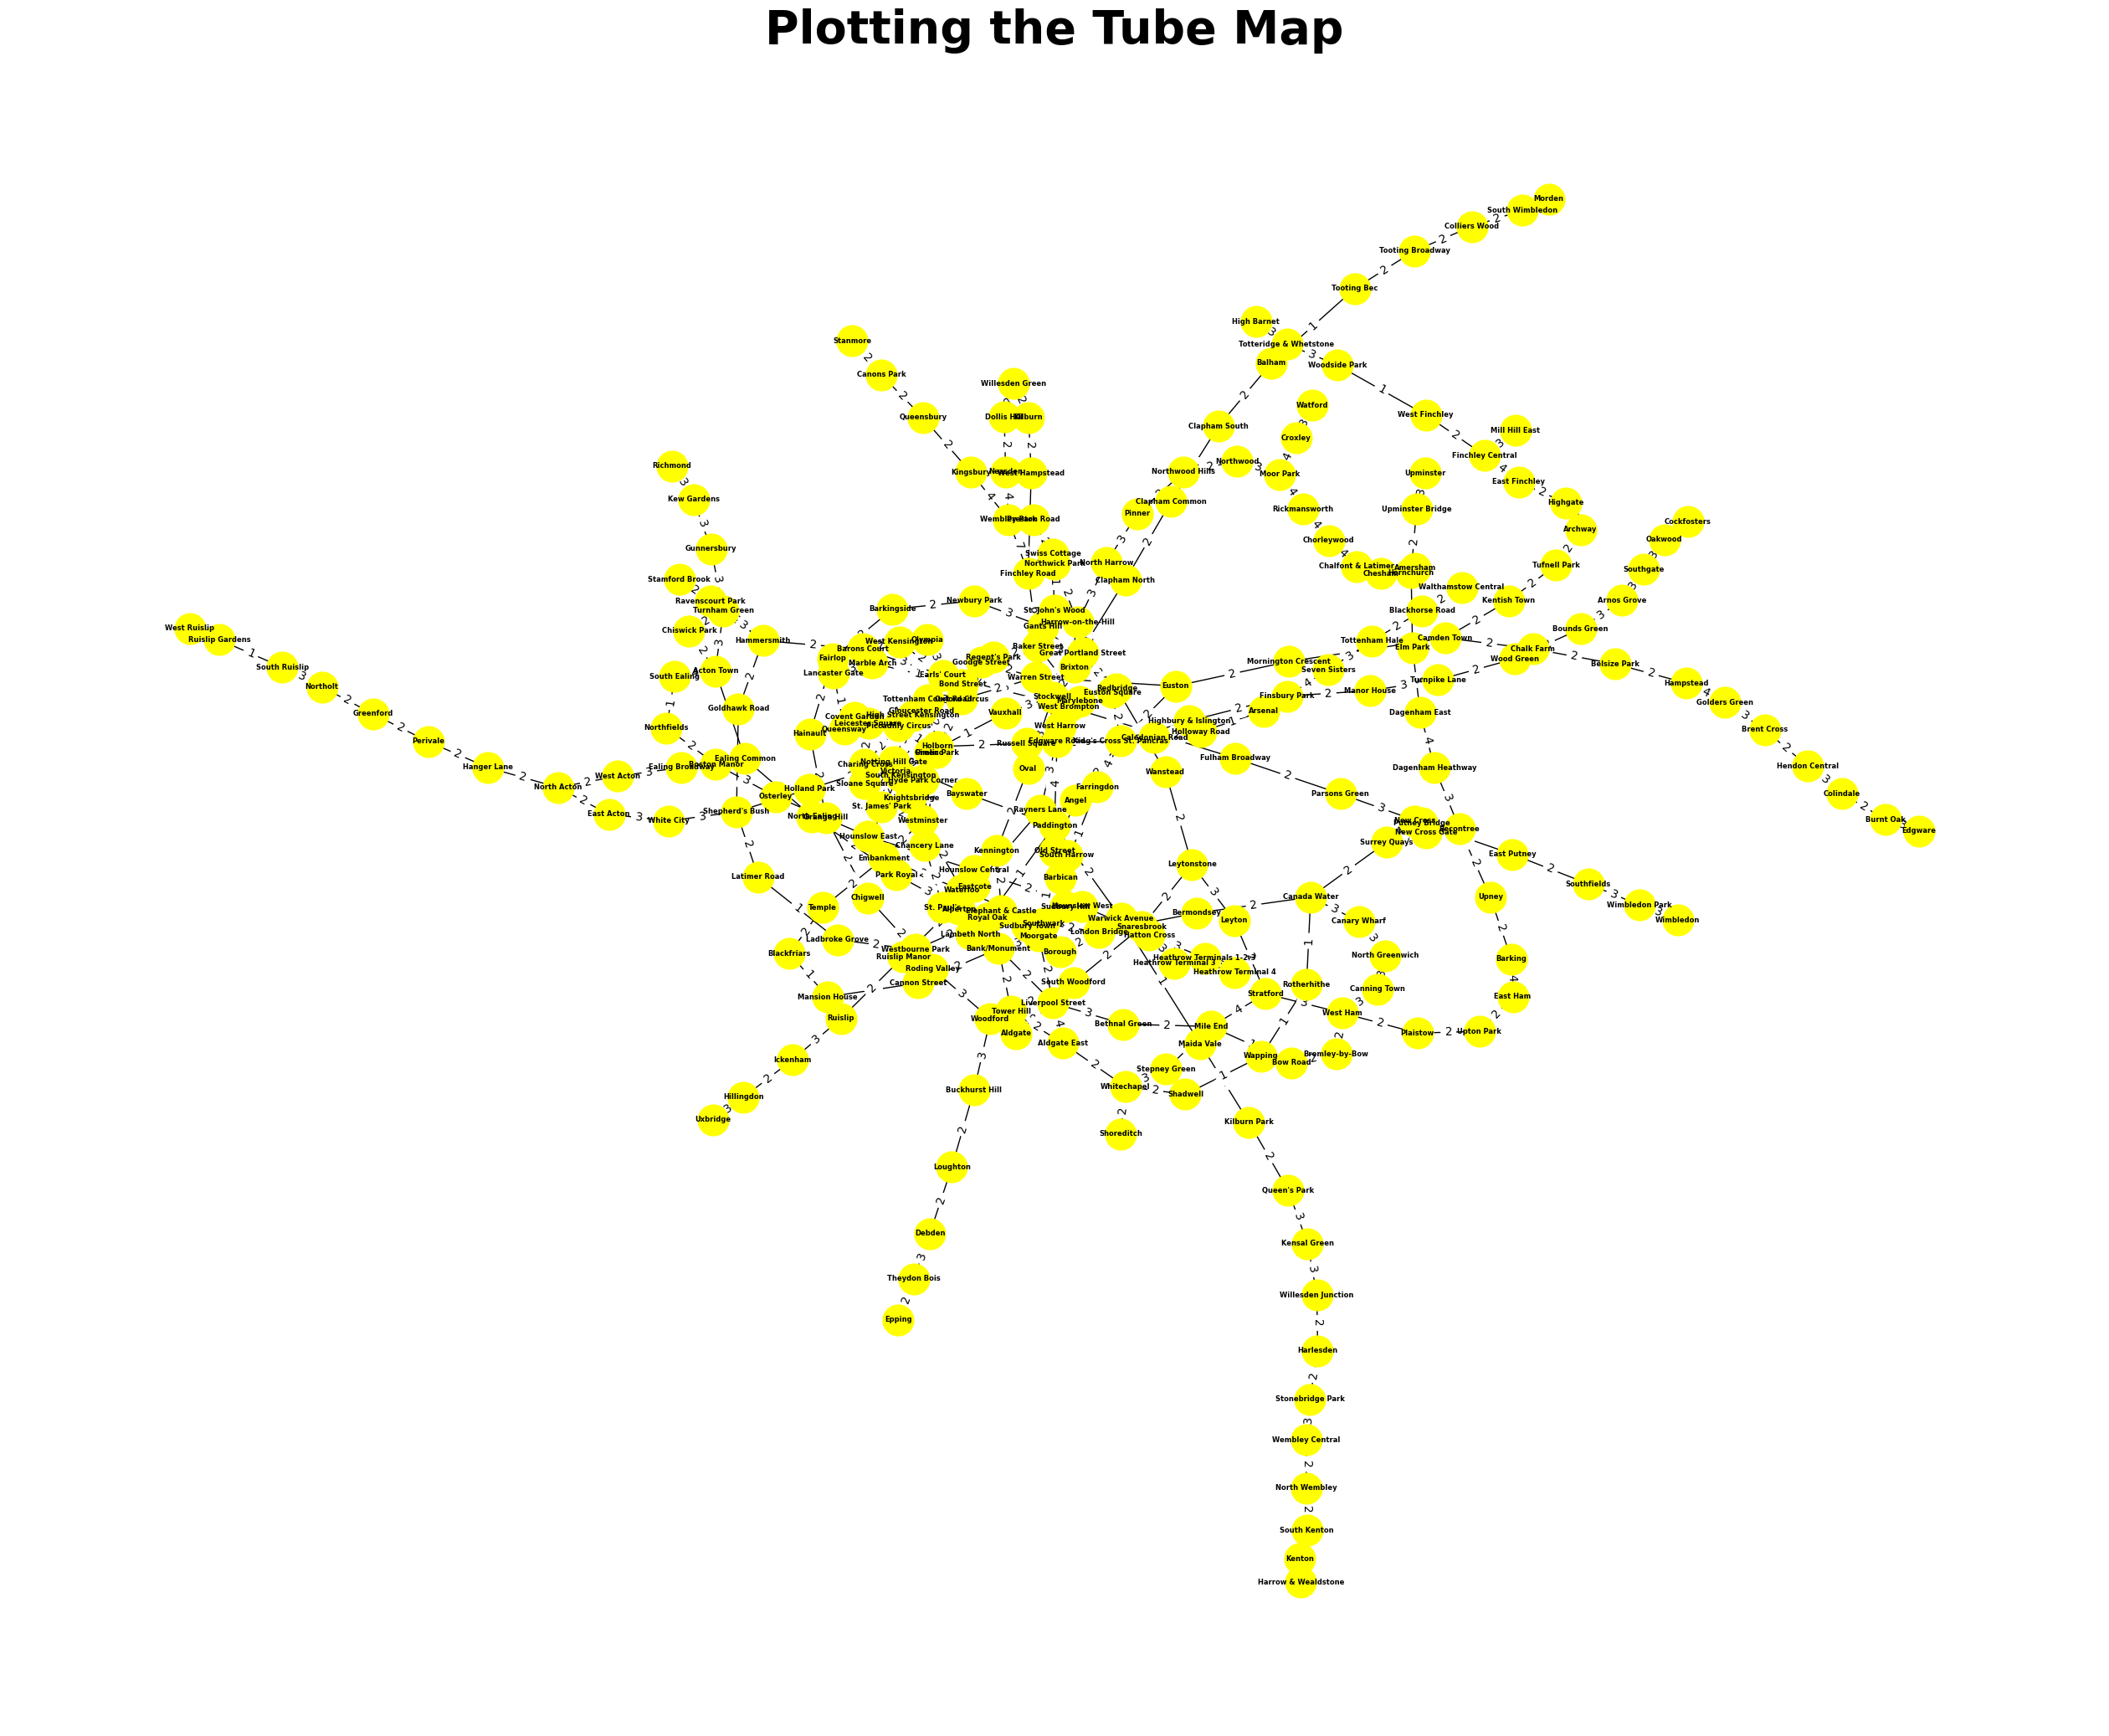

In [320]:
def plot_graph(graph_dict):
  G = nx.Graph()
  plt.figure(figsize=(25, 20))

  for station, neighbors in graph_dict.items():
      for neighbor, cost in neighbors:
          G.add_edge(station, neighbor, weight=cost)

  pos = nx.spring_layout(G)

  nx.draw(G, pos, with_labels = True, node_size = 700, node_color = 'yellow', font_size=6, 
          font_color = 'black', font_weight = 'bold', arrowsize=10)

  edge_labels = {(i, j): cost for i, edges in graph_dict.items() for j, cost in edges}
  nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
  plt.title("Plotting the Tube Map", fontsize = 40, fontweight = "bold")  
  plt.show()

plot_graph(station_dict)


## Genetic Algorithm
### 3.1 Implement a Genetic Algorithm
Implement a Genetic Algorithm to find your password. Report the true password (obtained as indicated above) and the password found (they should ideally match).|).

In [301]:
import math
import hashlib
import string
import numpy as np
import random

In [302]:
def get_password(student_username, l=10):
    # Possible characters include upper-case English letters, numbers between 0 and 9 (inclusive), 
    # and the underscore symbol
    options = string.digits + string.ascii_uppercase  + "_"

    h = hashlib.sha256(("ECS759P-AI"+student_username).encode("utf-8"))
    d = h.digest()
    s = ""
    for n in d:
      s += options[n%len(options)]

    return s[0:l]

# TO DO: replace *** with your EECS username and uncomment the code
student_password = get_password('ec23770')
print(student_password)

TJN7WJKWCD


In [303]:
# Distance function
def distance_function(string_one, string_two):
    score = 0
    for i, j in zip(string_one, string_two):
        # Square of the absolute difference between two Unicode codes
        score += math.sqrt(abs(ord(i) - ord(j)))
    return score


# Upper bound of the distance value
MAX_VALUE = distance_function('0000000000', '__________')

#Compute normalised fitness for a list of candidate passwords 
def get_normalised_fitness(list_of_phrases, student_password):
    ordered_dict = dict()
    phrase_to_find = student_password
    for phrase in list_of_phrases:
        # Return 1 when a candidate matches the true password (string distance between them is zero)
        ordered_dict[phrase] = 1 - distance_function(phrase, phrase_to_find) / MAX_VALUE
    return ordered_dict

# Example of how to get fitness values for a list of candidates
get_normalised_fitness(['2Q4HHHHOTJ', '2HHZQYUOTJ'], student_password)

{'2Q4HHHHOTJ': 0.5023217979444173, '2HHZQYUOTJ': 0.49681671209939304}

In [304]:
#Constants
POPULATION_SIZE = 1000
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.8
GENERATIONS = 1000

#Distance function
def distance_function(string_one, string_two):
    score = 0
    for i, j in zip(string_one, string_two):
        #Square of the absolute difference between two Unicode codes
        score += math.sqrt(abs(ord(i) - ord(j)))
    return score

#Maximum value of the distance value
MAX_VALUE = distance_function('0000000000', '____')

#Compute normalized fitness for a list of candidate passwords
def get_normalized_fitness(list_of_phrases, student_password):
    ordered_dict = dict()
    phrase_to_find = student_password
    for phrase in list_of_phrases:
        # Return 1 when a candidate matches the true password (string distance between them is zero)
        ordered_dict[phrase] = 1 - distance_function(phrase, phrase_to_find) / MAX_VALUE
    return ordered_dict

In [305]:
#Generate a random population of candidate passwords
def generate_population(population_size, password_length):
    population = [''.join(random.choices('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ_', k=password_length)) for _ in range(population_size)]
    return population

In [306]:
#Select parents for crossover based on their fitness
def selecting_parents(population, fitness_dict):
    sorted_population = sorted(population, key=lambda x: fitness_dict[x], reverse=True)
    total_fitness = sum(fitness_dict[x] for x in population)
    selected_parents = []

    for _ in range(2):  # Select 2 parents
        rand_num = random.uniform(0, total_fitness)
        current_sum = 0
        for candidate in sorted_population:
            current_sum += fitness_dict[candidate]
            if current_sum >= rand_num:
                selected_parents.append(candidate)
                break

    return selected_parents

In [307]:
#Perform crossover between the selected parents
def crossover(parent1, parent2, crossover_rate):
    if random.random() < crossover_rate:
        crossover_point = random.randint(0, len(parent1))
        child = parent1[:crossover_point] + parent2[crossover_point:]
    else:
        # If no crossover, one of the parents is selected as the child
        child = random.choice([parent1, parent2])

    return child

In [308]:
#Mutate a child with a certain probability
def mutation(child, mutation_rate):
    mutated_child = list(child)
    for i in range(len(mutated_child)):
        if random.random() < mutation_rate:
            mutated_child[i] = random.choice('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ_')
    return ''.join(mutated_child)

In [309]:
#Genetic Algorithm to print check if found password is same as true password
def genetic_algorithm(student_password, population_size, crossover_rate, mutation_rate):
    population = generate_population(population_size, len(student_password))
    generation = 0
    print(len(population))
    while True:
        fitness_dict = get_normalized_fitness(population, student_password)

        #Check if a perfect match is found
        if max(fitness_dict.values()) == 1:
            print(f"Password found in generation {generation + 1}!")
            break

        #Stop if a maximum number of generations is reached (optional)
        if generation >= MAX_GENERATIONS:
            print("Maximum number of generations reached. Exiting.")
            break

        #select parents, perform crossover, and mutate to create a new population
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = selecting_parents(population, fitness_dict)
            child1 = mutation(crossover(parent1, parent2, crossover_rate), mutation_rate)
            child2 = mutation(crossover(parent1, parent2, crossover_rate), mutation_rate)
            new_population.extend([child1, child2])


        population = new_population
        generation += 1


    #Print the best candidate password found
    best_candidate = max(fitness_dict, key = fitness_dict.get)
    print(f"Best candidate password: {get_normalized_fitness([best_candidate], student_password)}")
    return generation


#Example of how to use the genetic algorithm
student_password = 'TJN7WJKWCD'
MAX_GENERATIONS = 1000
num_generations = genetic_algorithm(student_password, population_size = 1000,
                                    crossover_rate = 0.8, mutation_rate = 0.1)

1000
Password found in generation 61!
Best candidate password: {'TJN7WJKWCD': 1.0}


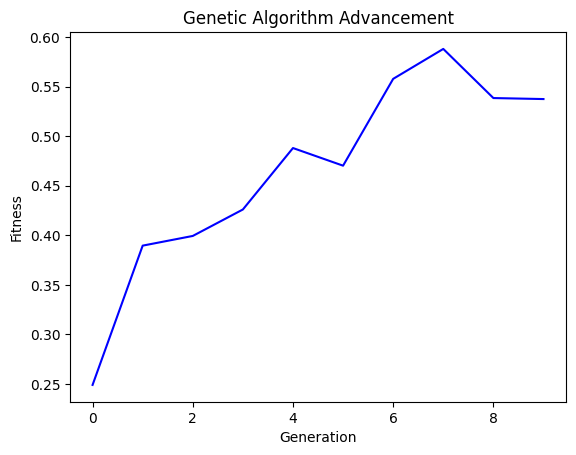

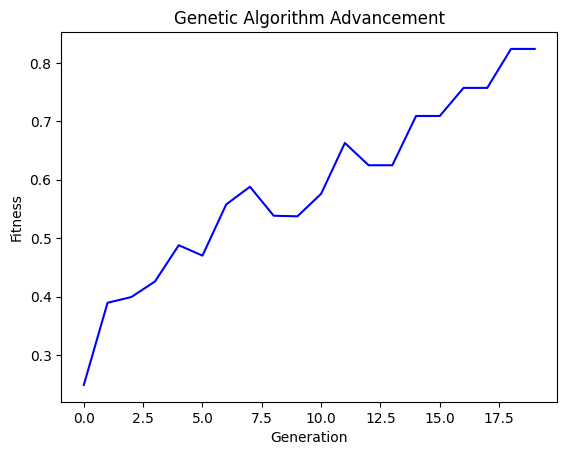

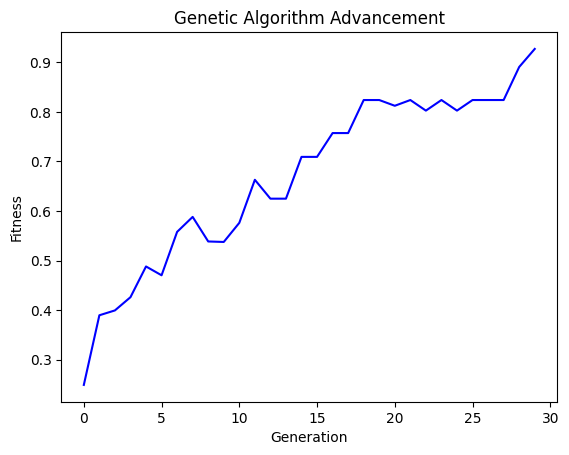

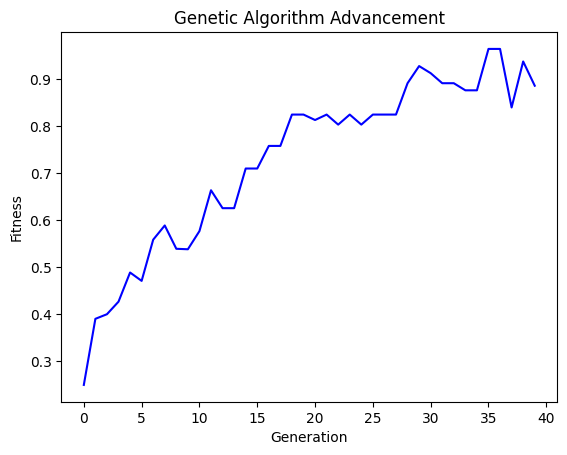

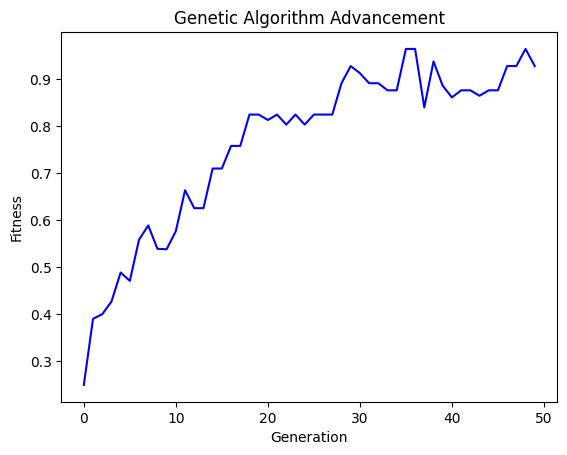

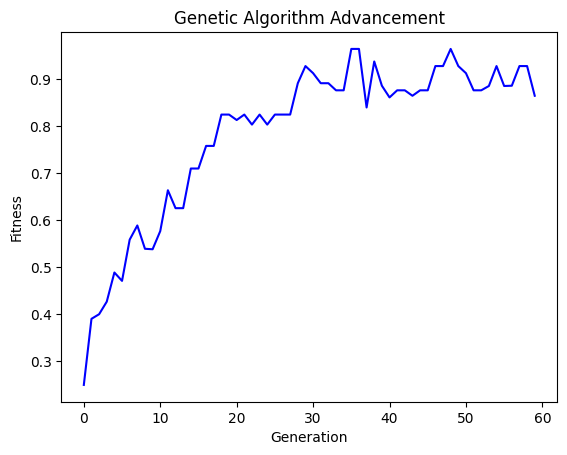

Password found in generation 70!
Best candidate password: {'XC_AXBYIUV': 1.0}


In [310]:
def genetic_algorithm(student_password, population_size, crossover_rate, mutation_rate, visualize=False):
    population = generate_population(population_size, len(student_password))
    generation = 0
    best_fitness_history = []

    while True:
        fitness_dict = get_normalized_fitness(population, student_password)

        # Check if a perfect match is found
        if max(fitness_dict.values()) == 1:
            print(f"Password found in generation {generation + 1}!")
            break

        # Terminate if a maximum number of generations is reached (optional)
        if generation >= MAX_GENERATIONS:
            print("Maximum number of generations reached. Exiting.")
            break

        # Select parents, perform crossover, and mutate to create a new population
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = selecting_parents(population, fitness_dict)
            child1 = mutation(crossover(parent1, parent2, crossover_rate), mutation_rate)
            child2 = mutation(crossover(parent1, parent2, crossover_rate), mutation_rate)
            new_population.extend([child1, child2])

        best_fitness = max(fitness_dict.values())
        best_fitness_history.append(best_fitness)

        population = new_population
        generation += 1

        # Visualization (moved outside of the loop)
        if visualize and generation % 10 == 0:
            visualizing_progress(generation, best_fitness_history)

    # Print the best candidate password found
    best_candidate = max(fitness_dict, key=fitness_dict.get)
    return best_candidate,generation
    
def visualizing_progress(generation, best_fitness_history):
    if best_fitness_history:
        plt.plot(range(generation), best_fitness_history, label='Best Fit',color = 'blue')
        plt.title('Genetic Algorithm Advancement')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.show()

# Example of how to use the genetic algorithm
student_password = 'XC_AXBYIUV'
MAX_GENERATIONS = 1000
best_candidate,num_generations = genetic_algorithm(student_password, population_size = 1000,
                                    crossover_rate = 0.8, mutation_rate = 0.1, visualize= True)
print(f"Best candidate password: {get_normalized_fitness([best_candidate], student_password)}")

### 3.3 Number of reproductions
Report the number of reproductions you had to perform to converge to the true password. Run your
code 5-10 times and report the average and standard deviation of the number of reproductions (since
Genetic Algorithms involve randomisation).

In [311]:
def average_and_std_of_reproduction(student_password,populationsize,crossoverrate,mutationrate):
    num_of_generations = []
    for i in range(10):
        best_candidate,num_generations = genetic_algorithm(student_password,population_size = 1000,crossover_rate = 0.8,mutation_rate = 0.1)
        num_of_generations.append(num_generations)
    
    average_of_reproduction = np.mean(num_of_generations)
    std_of_reproduction = np.std(num_of_generations)
    print(f'Population size {populationsize}, Crossover rate {crossoverrate} and Mutation rate {mutationrate} to converge to the password {best_candidate}')
    print("The average number of reproductions for is, ",average_of_reproduction)
    print("The standard deviation of reproductions is: ",std_of_reproduction)
    return average_of_reproduction,std_of_reproduction,num_of_generations

average_of_reproduction,std_of_reproduction,num_of_generations = average_and_std_of_reproduction(student_password, populationsize=1000,
                                    crossoverrate=0.8, mutationrate=0.1)

Password found in generation 55!
Password found in generation 52!
Password found in generation 60!
Password found in generation 61!
Password found in generation 69!
Password found in generation 84!
Password found in generation 135!
Password found in generation 109!
Password found in generation 47!
Password found in generation 57!
Population size 1000, Crossover rate 0.8 and Mutation rate 0.1 to converge to the password XC_AXBYIUV
The average number of reproductions for is,  71.9
The standard deviation of reproductions is:  26.994258648831238


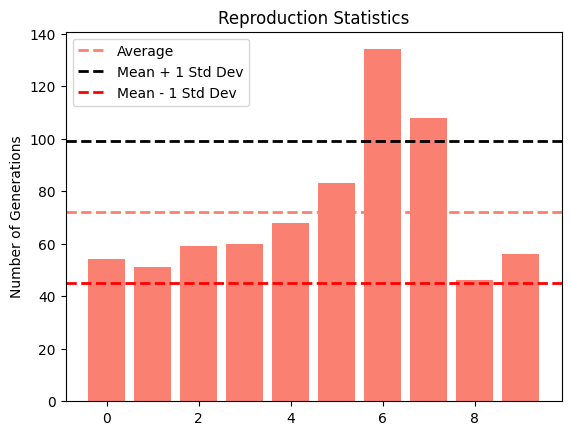

In [312]:
def visualize_reproduction_statistics_bar(num_of_generations):
    plt.bar(range(len(num_of_generations)), num_of_generations, color = 'salmon')
    plt.axhline(np.mean(num_of_generations), color = 'salmon', linestyle = 'dashed', linewidth = 2, label = 'Average')
    plt.axhline(np.mean(num_of_generations) + np.std(num_of_generations), color='black', linestyle = 'dashed', linewidth=2, label = 'Mean + 1 Std Dev')
    plt.axhline(np.mean(num_of_generations) - np.std(num_of_generations), color='red', linestyle = 'dashed', linewidth=2, label = 'Mean - 1 Std Dev')

    plt.ylabel('Number of Generations')
    plt.title('Reproduction Statistics')
    plt.legend()
    plt.show()

def visualize_reproduction_statistics_hist(mu,std,num_of_generations):
    #Fit a normal distribution to the data
    plt.hist(num_of_generations, bins='auto', density=True, alpha=0.7, color='salmon')

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.plot(x, p, color = 'salmon',linewidth=2)
    plt.grid(True)

    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.xlabel('Number of Generations')
    plt.ylabel('Frequency')
    plt.show()

#Visualize the reproduction statistics with a bar chart
visualize_reproduction_statistics_bar(num_of_generations)



### 3.4 Hyperparameters
Explore the effect of at least one hyperparameter on the performance of your algorithm. This could
be for instance trying at least two different mutation or crossover rates, two selection schemes, two
population sizes, etc. Provide a table that compares the average and the standard deviation of reproductions until convergence for each hyperparameter choice. Comment on which hyperparameter
value worked better and why.

In [313]:
hyperparameter_dic = {
    'POPULATION_SIZE': [1000,1000],
    'MUTATION_RATE': [0.13, 0.04],
    'CROSSOVER_RATE': [0.8,0.8],
    'AVERAGE_OF_REPRODUCTION': [],
    'STD_OF_REPRODUCTION': [],
}

print("\033[1m-----------------------------FOR TWO DIFFERENT MUTATION RATES---------------------------------\033[0m")
student_password = 'TJN7WJKWCD'
#genetic_algorithm(student_password)
for i in range(2):
    best_candidate,num_generations = genetic_algorithm(
        student_password,
        population_size=hyperparameter_dic['POPULATION_SIZE'][i],
        crossover_rate=hyperparameter_dic['CROSSOVER_RATE'][i],
        mutation_rate=hyperparameter_dic['MUTATION_RATE'][i],
    )
    print(f"POPULATION RATE {hyperparameter_dic['POPULATION_SIZE'][i]} \n CROSSOVER RATE {hyperparameter_dic['CROSSOVER_RATE'][i]} \n MUTATION RATE {hyperparameter_dic['MUTATION_RATE'][i]}")

    print(f"Best candidate password: {get_normalized_fitness([best_candidate], student_password)}")

-----------------------------FOR TWO DIFFERENT MUTATION RATES---------------------------------
Password found in generation 127!
POPULATION RATE 1000 
 CROSSOVER RATE 0.8 
 MUTATION RATE 0.13
Best candidate password: {'TJN7WJKWCD': 1.0}
Password found in generation 41!
POPULATION RATE 1000 
 CROSSOVER RATE 0.8 
 MUTATION RATE 0.04
Best candidate password: {'TJN7WJKWCD': 1.0}


In [314]:
student_password = 'TJN7WJKWCD'

for i in range(2):
    average_of_reproduction, std_of_reproduction, num_of_generations = average_and_std_of_reproduction(
        student_password,
        populationsize=hyperparameter_dic['POPULATION_SIZE'][i],
        crossoverrate=hyperparameter_dic['CROSSOVER_RATE'][i],
        mutationrate=hyperparameter_dic['MUTATION_RATE'][i]
    )
    hyperparameter_dic['AVERAGE_OF_REPRODUCTION'].append(average_of_reproduction)
    hyperparameter_dic['STD_OF_REPRODUCTION'].append(std_of_reproduction)

Password found in generation 75!
Password found in generation 114!
Password found in generation 77!
Password found in generation 115!
Password found in generation 53!
Password found in generation 115!
Password found in generation 73!
Password found in generation 45!
Password found in generation 59!
Password found in generation 38!
Population size 1000, Crossover rate 0.8 and Mutation rate 0.13 to converge to the password TJN7WJKWCD
The average number of reproductions for is,  75.4
The standard deviation of reproductions is:  27.782008566696543
Password found in generation 61!
Password found in generation 50!
Password found in generation 46!
Password found in generation 81!
Password found in generation 89!
Password found in generation 159!
Password found in generation 65!
Password found in generation 62!
Password found in generation 50!
Password found in generation 50!
Population size 1000, Crossover rate 0.8 and Mutation rate 0.04 to converge to the password TJN7WJKWCD
The average numb

In [315]:
df = pd.DataFrame(hyperparameter_dic)

In [316]:
df.head()

,POPULATION_SIZE,MUTATION_RATE,CROSSOVER_RATE,AVERAGE_OF_REPRODUCTION,STD_OF_REPRODUCTION
0,1000,0.13,0.8,75.4,27.782009
1,1000,0.04,0.8,70.3,32.143584
